In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sc
from scipy.optimize import minimize
from scipy.special import gamma
import dynesty
# from nestedSampling.saveDynesty import saveDynestyChain
import matplotlib.pyplot as plt
from getdist import plots, MCSamples, chains
from getdist import *
from dynesty import plotting as dyplot
%matplotlib inline

1- N points Uniform distributed en N-sphere. 

instead $ log L = log L_{max} - 0.5(x- \mu)^T \Sigma^{-1} (x-\mu)$, use:

   $ log L = log L_{max} - \alpha_d X^{2/d}$ 
   
   where $L_{max}$ and $X$ are unknown. 
   
   where d is the dimensionallity



In [23]:
def samplePoint(dims):    
    u = np.random.normal(0, 1, dims)  
    norm = np.sum(u**2)**0.5
    r = np.random.random()**(1.0/dims)
    x = r*u/norm
    return x

def samplingNSphere(npoints, dims):
    return np.array([samplePoint(dims) for i in range(npoints)])

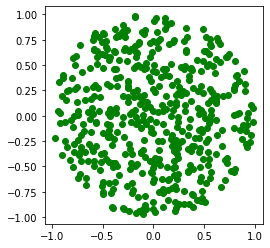

In [24]:
points2d = samplingNSphere(500, 2)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(points2d[:,0], points2d[:,1], c='g')
ax.set_aspect('equal', 'box')

(1000, 3)


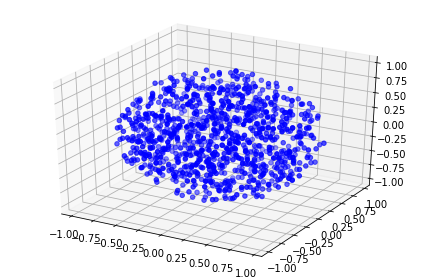

In [25]:
points3d = samplingNSphere(1000, 3)
print(points3d.shape)
fig = plt.figure()
# ax = fig.add_subplot(111,projection='3d')
ax = fig.gca(projection='3d')
plt.tight_layout()
ax.scatter(points3d[:,0], points3d[:,1], points3d[:, 2], c='b')

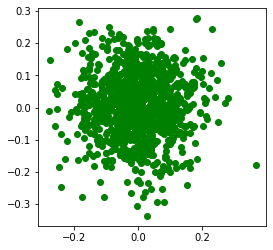

In [26]:
points4d = samplingNSphere(1000, 100)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(points4d[:,0], points4d[:,1], c='g')
ax.set_aspect('equal')
# ax = fig.add_subplot(111)
# ax.scatter(points4d[:,2], points4d[:,3], c='r')
# ax.set_aspect('equal')
plt.show()


- Define a spherical Likelihood:
  $logL = -\frac{x^2}{2\sigma^2}$


In [27]:
sigma = 0.5
# def sphereVolume(x):
# #     return -x**2/2/sigma**2
#     return 4/3*np.pi*np.sum(x**2)**(3/2)

def volNsphere(r, n):
    m = n / 2 + 1
    return r**n * (np.power(np.pi, n/2) / gamma(m))

def sphereLoglike(x):
    return -np.sum(x**2)/2/sigma**2

propossal fn: $log L = log L_{max} - \alpha_d X_i^{2/d}$

$X_i = \frac{V_n(r)}{V_{prior}}$ <- what is this $V_{prior}$ ?

$X_i = t_iX_{max}$ where $t_i \sim U(0,1)$

$t_i = \frac{X_i }{X_{max}} = \frac{i}{N} \implies X_i = \frac{iX_{max}}{N}$ with $i \in [1, N]$

Therefore:

$log L = log L_{max} - \alpha_d (\frac{iX_{max}}{N})^{2/d}$



In [28]:
x = np.array([1,1,1,1])
sphereLoglike(x)

-8.0

In [29]:
def propossalfn(logLmax, logxMax, i, alpha, d, N):
    xMax = np.exp(logxMax)
    return logLmax - alpha*np.sign(xMax)*(i*np.abs(xMax)/N)**(2/d)
#     return logLmax - alpha*volNsphere(r, d)**(2/d)

In [30]:
def logLike(theta, data, N):
#     points = data[0]
#     likes = data[0]
    loglmax, logxMax, alpha, d = theta
    sigma = 0.5
    i = np.arange(1, N+1)
    chisq = np.sum(((np.sort(data, axis=0) - propossalfn(loglmax, logxMax, i, alpha, d, N))/sigma)**2)
    
    return 0.5*chisq

def logLike_noDim(theta, data, N):
#     points = data[0]
#     likes = data[0]
    d=3
    loglmax, logxMax, alpha = theta
    sigma = 0.5
#     chisq = np.sum(((likes - propossalfn(points, loglmax, alpha, d))/sigma)**2)
    i = np.arange(1, N+1)
    chisq = np.sum(((np.sort(data) - propossalfn(loglmax, logxMax, i, alpha, d, N))/sigma)**2)
    
    return 0.5*chisq

Following plots must have the form : $log L = log L_{max} - \alpha_d X^{2/d}$

### 2D

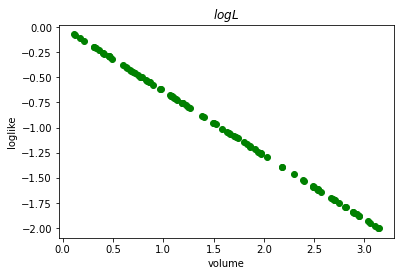

In [175]:
npoints = 100
points2d = samplingNSphere(npoints, 2)

likes2d = np.zeros((npoints, 1))
volumes2d = np.zeros((npoints, 1))


for i, p in enumerate(points2d):
    likes2d[i] = sphereLoglike(p)
    r = np.sqrt(np.sum(p**2))
    volumes2d[i] = volNsphere(r, 2)
       

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(volumes2d, likes2d, c='g')
ax.set_aspect('equal', 'box')

plt.xlabel("volume")
plt.ylabel("loglike")
plt.title("$log L $")
plt.show()

### 3D

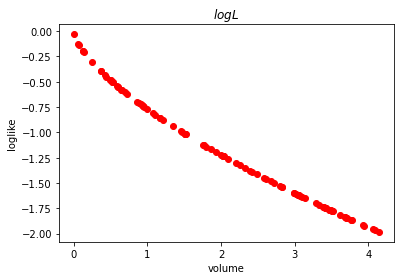

In [176]:
npoints = 100
points3d = samplingNSphere(npoints, 3)
likes3d = np.zeros((npoints, 1))
volumes3d = np.zeros((npoints, 1))

for i, p in enumerate(points3d):
    likes3d[i] = sphereLoglike(p)
    r = np.sqrt(np.sum(p**2))
    volumes3d[i] = volNsphere(r, 3)
    
plt.scatter(volumes3d, likes3d, c='r')
plt.xlabel("volume")
plt.ylabel("loglike")
plt.title("$log L $")
plt.show()    

In [177]:
# saving samples
samples = np.concatenate([points3d, likes3d], axis=1)
idx = 10
print(points3d[idx], likes3d[idx])
samples[idx]
# np.sort(likes3d) #Not use i

[-0.59656683  0.04845424  0.37224984] [-0.99361947]


array([-0.59656683,  0.04845424,  0.37224984, -0.99361947])

In [276]:
N = len(likes3d)
sigmaLike = 0.5
logL_bounds = (-2*3, 0)
alpha_bounds = (0, 1)
d_bounds = (1, 10)
logxMax_bounds = (-1e2, 0)
bounds = [logL_bounds, logxMax_bounds, alpha_bounds, d_bounds]
bounds
bounds_noDim = [logL_bounds, logxMax_bounds, alpha_bounds]

Trying to minimize given -loglike and proposal function:

In [277]:
N = len(likes3d)
X_max3d = np.max(volumes3d)
tmp_max_logl3d = np.max(likes3d)
print("Current max logl: {}".format(tmp_max_logl3d))
# op = minimize(logLike,  [tmp_max_logl3d, 0.01, 0.5, 1], samples)
#logLmax, X, i, alpha, d
op = minimize(logLike,  [tmp_max_logl3d, -0.5, 0.5, 3] , (likes3d, N))
print("Max like: {}, logxMax: {}, max alpha: {}, d:"\
      "{}".format(op.x[0], op.x[1], op.x[2], op.x[3]))

Current max logl: -0.030132471809266974
Max like: -1.187232514436931, logxMax: -0.368573316818469, max alpha: 0.49375525408539545, d:2.069258875873031


In [318]:
op = minimize(logLike_noDim,  [tmp_max_logl3d, -0.5, 0.5] , (likes3d, N))
print("Max like: {}, logxMax: {}, max alpha: {}".format(op.x[0], op.x[1], op.x[2]))

Max like: -1.1776407977447696, logxMax: 0.3237952729690799, max alpha: -9.473495994205168e-08


Sampling the posterior distribution for this set of live points

In [291]:
bounds = bounds_noDim
def priorTransform(theta):
    points = []
    for c, bound in enumerate(bounds):
        points.append(theta[c]*(bound[1]-bound[0])+bound[0])
    return points

def logLikelihood3d(theta):
    return logLike_noDim(theta, likes3d, N)


In [306]:
sampler = dynesty.NestedSampler(logLikelihood3d, priorTransform, 3, bound='multi', sample='unif', nlive=100)
sampler.run_nested(dlogz=0.01)

7792it [00:07, 1034.10it/s, +100 | bound: 95 | nc: 1 | ncall: 18371 | eff(%): 42.959 | loglstar:   -inf < 591628.806 <    inf | logz: 591555.883 +/-  1.104 | dlogz:  0.000 >  0.010]


In [307]:
print(sampler.results.keys())

dict_keys(['nlive', 'niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_it', 'samples_u', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'bound', 'bound_iter', 'samples_bound', 'scale'])


In [308]:
sampler.results.summary()

Summary
nlive: 100
niter: 7792
ncall: 18371
eff(%): 42.959
logz: 591555.883 +/-  1.104


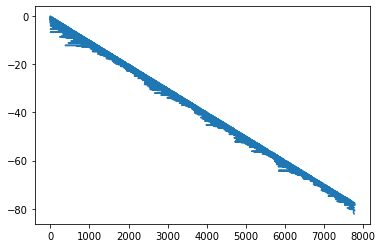

In [309]:
# plt.plot(sampler.results['samples_it'], sampler.results['logvol'])

In [312]:
results = sampler.results
saveDynestyChain(results, "outputs/dynestySamples3DBall")


 Number of posterior samples is 7892


In [313]:
filename = '/home/isidro/Documents/gitHub/misRepos/nestedSampling/outputs/dynestySamples3DBall'
mcsamplefile = mcsamples.loadMCSamples(filename, ini=None, jobItem=None, no_cache=False)

mcstats = mcsamplefile.getLikeStats()
for i in range(3):
    print(mcstats.list()[i])
    top = mcstats.names[i].ND_limit_top[1]
    low = mcstats.names[i].ND_limit_bot[1]
    best = mcstats.names[i].bestfit_sample

    print("Best: {:.5}".format(best))
    print("Mean: {:.5}".format(mcsamplefile.getMeans()[i]))
    print("Top value: {:.5}".format(top))
    print("Lower value: {:.5}".format(low))
    print("Std dev: {:.4}".format((mcsamplefile.std(mcstats.list()[i]))))
    print("-"*20)

/usr/local/lib/python3.6/dist-packages/getdist/chains.py:1149: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  weights = None if self.chains[0].weights is None else np.hstack((chain.weights for chain in self.chains))
/usr/local/lib/python3.6/dist-packages/getdist/chains.py:1150: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  loglikes = None if self.chains[0].loglikes is None else np.hstack((chain.loglikes for chain in self.chains))
/usr/local/lib/python3.6/dist-packages/getdist/chains.py:1151: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of 

/home/isidro/Documents/gitHub/misRepos/nestedSampling/outputs/dynestySamples3DBall.txt
Removed no burn in
logL
Best: -5.9948
Mean: -5.9905
Top value: -5.9819
Lower value: -6.0
Std dev: 0.001878
--------------------
logX
Best: -0.028923
Mean: -0.012001
Top value: -1.1024e-05
Lower value: -0.044036
Std dev: 0.00473
--------------------
alpha
Best: 0.99142
Mean: 0.988
Top value: 0.99462
Lower value: 0.9828
Std dev: 0.000559
--------------------


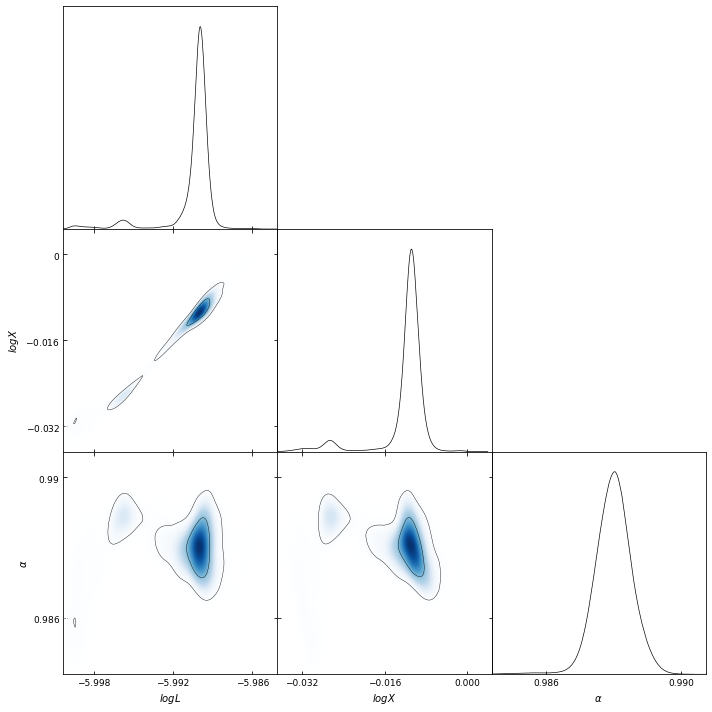

In [316]:
g = plots.getSubplotPlotter(width_inch=10,
                           analysis_settings={'smooth_scale_2D': 0.8,
                                              'smooth_scale_1D': 0.8})

g.settings.lab_fontsize = 10
g.settings.legend_fontsize = 9
g.settings.axes_fontsize = 9

g.triangle_plot(mcsamplefile,['logL', 'logX', 'alpha'], 
                filled = False, 
                shaded=True)
plt.savefig("posterior3Dball_fixD.png")

### 4D

In [ ]:
npoints = 100
points4d = samplingNSphere(npoints, 4)
likes4d = np.zeros((npoints, 1))
volumes4d = np.zeros((npoints, 1))

for i, p in enumerate(points4d):
    likes4d[i] = sphereLoglike(p)  
    r = np.sqrt(np.sum(p**2))
    volumes4d[i] = volNsphere(r, 4)
    
    
plt.scatter(volumes4d, likes4d, c='k')
plt.xlabel("volume")
plt.ylabel("loglike")
plt.title("$log L $")
plt.show()
    

In [ ]:
# saving samples
samples4d = np.concatenate([points4d, likes4d], axis=1)
idx = 10
print(points4d[idx], likes4d[idx])


#trying to minimize loglike
X_max4d = np.max(volumes4d)
tmp_max_logl4d = np.max(likes4d)
print("Current max logl: {}".format(tmp_max_logl4d))
op = minimize(logLike,  [tmp_max_logl4d, 0.9, 0.5, 4] , (likes4d, N))
print("Max like: {}, maxX: {}, max alpha: {}, d:"\
      "{}".format(op.x[0], op.x[1], op.x[2], op.x[3]))
# alpha->op.x[1]


In [ ]:
N = len(likes4d)
sigmaLike = 0.5
logL_bounds = [np.min(likes4d)-sigmaLike, np.max(likes4d)+sigmaLike]
alpha_bounds = [0, 1]
d_bounds = [3.999, 4.001]
xMax_bounds = [0, 1]
bounds = [logL_bounds, xMax_bounds, alpha_bounds, d_bounds]
bounds

In [ ]:
def priorTransform(theta):
    points = []
    for c, bound in enumerate(bounds):
        points.append(theta[c]*(bound[1]-bound[0])+bound[0])
    return points

def logLikelihood4d(theta):
    return logLike(theta, likes4d, N)

In [ ]:
sampler = dynesty.NestedSampler(logLikelihood4d, priorTransform, 4, bound='multi', sample='slice', nlive=500)
sampler.run_nested(dlogz=0.01)

In [ ]:
sampler.results.summary()

In [ ]:
results = sampler.results
saveDynestyChain(results, "outputs/dynestySamples4DBall")

In [ ]:
filename = '/home/isidro/Documents/gitHub/misRepos/nestedSampling/outputs/dynestySamples4DBall'
mcsamplefile = mcsamples.loadMCSamples(filename, ini=None, jobItem=None, no_cache=False)

mcstats = mcsamplefile.getLikeStats()
for i in range(4):
    print(mcstats.list()[i])
    top = mcstats.names[i].ND_limit_top[1]
    low = mcstats.names[i].ND_limit_bot[1]
    best = mcstats.names[i].bestfit_sample

    print("Best: {:.5}".format(best))
    print("Mean: {:.5}".format(mcsamplefile.getMeans()[i]))
    print("Top value: {:.5}".format(top))
    print("Lower value: {:.5}".format(low))
    print("Std dev: {:.4}".format((mcsamplefile.std(mcstats.list()[i]))))
    print("-"*20)

In [ ]:
g = plots.getSubplotPlotter(width_inch=10,
                           analysis_settings={'smooth_scale_2D': 0.5,
                                              'smooth_scale_1D': 0.5})

g.settings.lab_fontsize = 15
g.settings.legend_fontsize = 12
g.settings.axes_fontsize = 12

g.triangle_plot(mcsamplefile,['logL', 'X', 'i', 'alpha', 'd'], 
                filled = False, 
                shaded=True)

### 5D

In [ ]:
npoints = 100
points5d = samplingNSphere(npoints, 5)
likes5d = np.zeros((npoints, 1))
volumes5d = np.zeros((npoints, 1))

for i, p in enumerate(points5d):
    likes5d[i] = sphereLoglike(p)
    
    r = np.sqrt(np.sum(p**2))
    volumes5d[i] = volNsphere(r, 5)
    
plt.scatter(volumes5d, likes5d, c='y')
plt.xlabel("volume")
plt.ylabel("loglike")
plt.title("$log L $")
plt.show()

In [ ]:
# saving samples
samples5d = np.concatenate([points5d, likes5d], axis=1)
idx = 10
print(points5d[idx], likes5d[idx])


#trying to minimize loglike
X_max5d = np.max(volumes5d)
tmp_max_logl5d = np.max(likes5d)
print("Current max logl: {}".format(tmp_max_logl5d))
op = minimize(logLike,  [tmp_max_logl5d, 0.01], samples5d)
print("Max like: {}, max alpha: {}".format(op.x[0], op.x[1]))
# alpha->op.x[1]
